# Refine Woodward rules for alpha,beta substituted Carbonyl compounds


In [31]:
import sys, os
import pandas as pd
import numpy as np

from rdkit import Chem

sys.path.append('../../Woodward_Fieser_Rules-main/src/')
import chromopredict as cp

In [51]:
def unpack_data(df):
    # Constants
    HARTREE_TO_EV = 27.2116
    EV_TO_NM = 1239.841984  # Planck constant * speed of light in nm·eV

    # Function to convert string to list of floats
    def parse_str_array(s):
        s = s.strip("[]").replace("\n", " ")  # Remove brackets and newline
        return [float(x) for x in s.split()]
    
    # Apply the parsing function
    df['eigenvalues'] = df['eigenvalues'].apply(parse_str_array)
    df['oscillator_strengths'] = df['oscillator_strengths'].apply(parse_str_array)
    
    # Now unpack and convert
    for i in range(10):
        # Extract raw eigenvalue
        df[f'E{i+1}'] = df['eigenvalues'].apply(lambda x: x[i]) * HARTREE_TO_EV
        df[f'f{i+1}'] = df['oscillator_strengths'].apply(lambda x: x[i])
        df[f'nm{i+1}'] = df[f'E{i+1}'].apply(lambda x: round(EV_TO_NM / x,1) if x != 0 else np.nan)

    df = df.drop(columns=['eigenvalues', 'oscillator_strengths'])
    
    return df
    
def load_ref_data(path, category, func='b3lyp'):

    df_raw = pd.read_csv(path)
    df_unpack = unpack_data(df_raw)
    df_unpack['solvent'] = None
    df_unpack['moltype'] = category
    
    df_use = df_unpack[['smiles', 'moltype', 'solvent', 'nm2']].rename(columns={'nm2': 'nm_'+str(func)})

    return df_use
    

In [52]:
#df_aldehydes_mix = load_ref_data('opt_dft/data_aldehydes_mix_calc_195v195.csv', category='aldehyde')
df_aldehydes_mono = load_ref_data('opt_dft/data_b3lyp_aldehyd_mono_calc_36v36.csv', func='b3lyp', category='aldehyde')

#df_ketones_mix = load_ref_data('opt_dft/data_ketones_mix_calc_195V195.csv', category='ketone')
df_ketones_mono = load_ref_data('opt_dft/data_b3lyp_keton_mono_calc_36v36.csv', func='b3lyp', category='ketone')

#df_acids_mix = load_ref_data('opt_dft/data_acids_mix_calc_195v195.csv', category='acid')
df_acids_mono = load_ref_data('opt_dft/data_b3lyp_acid_mono_calc_36v36.csv', func='b3lyp', category='acid')


In [53]:
df_all = pd.concat([df_aldehydes_mono, df_ketones_mono, df_acids_mono], axis=0)
df_all

,smiles,moltype,solvent,nm_b3lyp
0,O=CC(C)=C(C)C,aldehyde,None,245.5
1,O=C/C(C)=C/C,aldehyde,None,239.6
2,O=C/C(C)=C\C,aldehyde,None,240.0
3,O=CC(C)=C,aldehyde,None,209.4
4,O=CC(OC)=C(OC)OC,aldehyde,None,256.2
...,...,...,...,...
31,O=C(O)/C=C\OC,acid,None,220.1
32,O=C(O)/C=C\Cl,acid,None,218.9
33,O=C(O)/C=C\Br,acid,None,237.2
34,O=C(O)/C=C\O,acid,None,214.8


In [54]:
from rdkit import Chem
from rdkit.Chem import rdchem

def detect_cis_trans(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return None

    for bond in mol.GetBonds():
        if bond.GetBondType() == rdchem.BondType.DOUBLE:
            stereo = bond.GetStereo()
            if stereo == rdchem.BondStereo.STEREOZ:
                return 'cis'
            elif stereo == rdchem.BondStereo.STEREOE:
                return 'trans'
    return 'no_stereo'

# Apply to create a mask
df_all['stereo_type'] = df_all['smiles'].apply(detect_cis_trans)

df_all.head(n=3)

,smiles,moltype,solvent,nm_b3lyp,stereo_type
0,O=CC(C)=C(C)C,aldehyde,None,245.5,no_stereo
1,O=C/C(C)=C/C,aldehyde,None,239.6,trans
2,O=C/C(C)=C\C,aldehyde,None,240.0,cis


In [55]:
def get_wf_outputs(smiles, solvent=None, debug=False, extended=False, multi=False):
    pred, d_contrib, img = cp.predict(smiles, solvent, debug=debug, draw=False, extended=extended, multi=multi)
    return pred, d_contrib, img #pd.Series([pred, d_contrib, img], index=['nm_wf', 'img_wf'])

def add_wf_predict(df):

    nm_wf = []
    img_wf = []
    contrib_wf = []

    nm_wfe = []
    img_wfe = []
    contrib_wfe = []
    
    for _, row in df.iterrows():
        smi = row['smiles']
        solv = row['solvent']
        # woodward
        nm, d_contrib, img = get_wf_outputs(smi, solv, debug=True, extended=False, multi=False)
        nm_wf.append(nm)
        contrib_wf.append(d_contrib)
        img_wf.append(img)
        
        # woodward extended
        nm, d_contrib, img = get_wf_outputs(smi, solv, debug=True, extended=True, multi=False)
        nm_wfe.append(nm)
        contrib_wfe.append(d_contrib)
        img_wfe.append(img)
        
        
    df['nm_wf'] = nm_wf
    df['nm_wfe'] = nm_wfe
    
    df['contrib_wf'] = contrib_wf
    df['contrib_wfe'] = contrib_wfe
    
    df['img_wf'] = img_wf
    df['img_wfe'] = img_wfe


In [56]:
add_wf_predict(df_all)


In [58]:
df_tmp = df_all[['moltype', 'smiles', 'solvent', 'stereo_type', 'nm_b3lyp', 'nm_wf', 'contrib_wf']]

contrib_expanded = df_tmp['contrib_wf'].apply(pd.Series)
df_wf_all = pd.concat([df_tmp.drop(columns='contrib_wf'), contrib_expanded], axis=1)

df_wf_all.head(n=5)

,moltype,smiles,solvent,stereo_type,nm_b3lyp,nm_wf,base,factor,exo,alpha,beta,gamma,higher,solvent
0,aldehyde,O=CC(C)=C(C)C,None,no_stereo,245.5,232,210,0,0,alkyl,alkyl,H,H,0
1,aldehyde,O=C/C(C)=C/C,None,trans,239.6,232,210,0,0,alkyl,alkyl,H,H,0
2,aldehyde,O=C/C(C)=C\C,None,cis,240.0,232,210,0,0,alkyl,alkyl,H,H,0
3,aldehyde,O=CC(C)=C,None,no_stereo,209.4,220,210,0,0,alkyl,H,H,H,0
4,aldehyde,O=CC(OC)=C(OC)OC,None,no_stereo,256.2,275,210,0,0,alkoxy,alkoxy,H,H,0


In [60]:
df_4fit_wf = df_wf_all[['moltype', 'smiles', 'stereo_type', 'nm_b3lyp', 'nm_wf', 'alpha', 'beta']]
df_4fit_wf['base'] = df_4fit_wf['moltype'] + '_' + df_4fit_wf['stereo_type']

df_4fit_wf.head(n=5)

/tmp/ipykernel_533885/2076031526.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4fit_wf['base'] = df_4fit_wf['moltype'] + '_' + df_4fit_wf['stereo_type']


,moltype,smiles,stereo_type,nm_b3lyp,nm_wf,alpha,beta,base
0,aldehyde,O=CC(C)=C(C)C,no_stereo,245.5,232,alkyl,alkyl,aldehyde_no_stereo
1,aldehyde,O=C/C(C)=C/C,trans,239.6,232,alkyl,alkyl,aldehyde_trans
2,aldehyde,O=C/C(C)=C\C,cis,240.0,232,alkyl,alkyl,aldehyde_cis
3,aldehyde,O=CC(C)=C,no_stereo,209.4,220,alkyl,H,aldehyde_no_stereo
4,aldehyde,O=CC(OC)=C(OC)OC,no_stereo,256.2,275,alkoxy,alkoxy,aldehyde_no_stereo


In [78]:
# One-hot encode features
X_base = pd.get_dummies(df_4fit_wf['base'], prefix='base')
X_alpha = pd.get_dummies(df_4fit_wf['alpha'], prefix='alpha')
X_beta = pd.get_dummies(df_4fit_wf['beta'], prefix='beta')

# Combine into one feature matrix
X = pd.concat([X_base, X_alpha, X_beta], axis=1)
y = df_4fit_wf['nm_b3lyp']

feature_names = X.columns.tolist()

In [79]:
initial_guesses = {
    # Base values (from original Woodward rules)
    'base_acid_cis': 195,
    'base_acid_no_stereo': 195,
    'base_acid_trans': 195,
    'base_aldehyde_cis': 210,
    'base_aldehyde_no_stereo': 210,
    'base_aldehyde_trans': 210,
    'base_ketone_cis': 215,
    'base_ketone_no_stereo': 215,
    'base_ketone_trans': 215,
    
    # Alpha substituent increments (default = 0, unless known)
    'alpha_H': 0,
    'alpha_alkoxy': 35,
    'alpha_alkyl': 10,
    'alpha_bromo': 25,
    'alpha_chloro': 15,
    'alpha_hydroxy': 35,
    
    # Beta substituent increments (usually less than alpha)
    'beta_H': 0,
    'beta_alkoxy': 30,
    'beta_alkyl': 12,
    'beta_bromo': 30,
    'beta_chloro': 12,
    'beta_hydroxy': 30
}

x0 = np.array([initial_guesses.get(f, 0) for f in feature_names])
x0

array([195, 195, 195, 210, 210, 210, 215, 215, 215,   0,  35,  10,  25,
        15,  35,   0,  30,  12,  30,  12,  30])

### Fit Woodward parameters to DFT data

In [80]:
from scipy.optimize import dual_annealing
import numpy as np

# Define Loss Function
def integer_loss_fn(coefs):
    coefs_int = np.round(coefs)
    pred = X @ coefs_int
    return np.sum((pred - y) ** 2)

# Set bounds
bounds = []
for f in feature_names:
    if f in ['alpha_H', 'beta_H']:
        bounds.append((0, 0.001))
    #elif f in ['alpha_alkyl']:
    #    bounds.append((10, 10.001))
    #elif f in ['beta_alkyl']:
    #    bounds.append((12, 12.001))
    elif 'base' in f:
        bounds.append((150, 300))
    else:
        bounds.append((1, 50))

# Run global optimizer
result = dual_annealing(integer_loss_fn, bounds, x0=x0)

# Round final coefficients
fitted_int_coefs = np.round(result.x).astype(int)

# Convert to pandas Series
fitted_series = pd.Series(fitted_int_coefs, index=feature_names)

In [81]:
fitted_series


base_acid_cis              189
base_acid_no_stereo        198
base_acid_trans            193
base_aldehyde_cis          210
base_aldehyde_no_stereo    213
base_aldehyde_trans        218
base_ketone_cis            202
base_ketone_no_stereo      213
base_ketone_trans          206
alpha_H                      0
alpha_alkoxy                40
alpha_alkyl                 10
alpha_bromo                 39
alpha_chloro                29
alpha_hydroxy               36
beta_H                       0
beta_alkoxy                 19
beta_alkyl                  14
beta_bromo                  38
beta_chloro                 25
beta_hydroxy                19
dtype: int64

### Woodward vs. DFT-refined Woodward

Add updated list of values to dataset and compare original woodward predictiosn with refined values

In [86]:
def get_value(row, col_prefix):
    key = f"{col_prefix}_{row[col_prefix]}"
    return fitted_series.get(key, 0)

In [87]:
df_4fit_wf['alpha_val'] = df_4fit_wf.apply(lambda row: get_value(row, 'alpha'), axis=1)
df_4fit_wf['beta_val']  = df_4fit_wf.apply(lambda row: get_value(row, 'beta'), axis=1)
df_4fit_wf['base_val']  = df_4fit_wf.apply(lambda row: get_value(row, 'base'), axis=1)

df_4fit_wf

/tmp/ipykernel_533885/4291798030.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4fit_wf['alpha_val'] = df_4fit_wf.apply(lambda row: get_value(row, 'alpha'), axis=1)
/tmp/ipykernel_533885/4291798030.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4fit_wf['beta_val']  = df_4fit_wf.apply(lambda row: get_value(row, 'beta'), axis=1)
/tmp/ipykernel_533885/4291798030.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

,moltype,smiles,stereo_type,nm_b3lyp,nm_wf,alpha,beta,base,alpha_val,beta_val,base_val,nm_wf_refine
0,aldehyde,O=CC(C)=C(C)C,no_stereo,245.5,232,alkyl,alkyl,aldehyde_no_stereo,10,14,213,237
1,aldehyde,O=C/C(C)=C/C,trans,239.6,232,alkyl,alkyl,aldehyde_trans,10,14,218,242
2,aldehyde,O=C/C(C)=C\C,cis,240.0,232,alkyl,alkyl,aldehyde_cis,10,14,210,234
3,aldehyde,O=CC(C)=C,no_stereo,209.4,220,alkyl,H,aldehyde_no_stereo,10,0,213,223
4,aldehyde,O=CC(OC)=C(OC)OC,no_stereo,256.2,275,alkoxy,alkoxy,aldehyde_no_stereo,40,19,213,272
...,...,...,...,...,...,...,...,...,...,...,...,...
31,acid,O=C(O)/C=C\OC,cis,220.1,225,H,alkoxy,acid_cis,0,19,189,208
32,acid,O=C(O)/C=C\Cl,cis,218.9,200,H,chloro,acid_cis,0,25,189,214
33,acid,O=C(O)/C=C\Br,cis,237.2,205,H,bromo,acid_cis,0,38,189,227
34,acid,O=C(O)/C=C\O,cis,214.8,225,H,hydroxy,acid_cis,0,19,189,208


In [91]:
df_4fit_wf['nm_wf_refine'] = df_4fit_wf['alpha_val'] + df_4fit_wf['beta_val'] + df_4fit_wf['base_val']
df_4fit_wf.head(n=50)

/tmp/ipykernel_533885/1707629532.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4fit_wf['nm_wf_refine'] = df_4fit_wf['alpha_val'] + df_4fit_wf['beta_val'] + df_4fit_wf['base_val']


,moltype,smiles,stereo_type,nm_b3lyp,nm_wf,alpha,beta,base,alpha_val,beta_val,base_val,nm_wf_refine
0,aldehyde,O=CC(C)=C(C)C,no_stereo,245.5,232,alkyl,alkyl,aldehyde_no_stereo,10,14,213,237
1,aldehyde,O=C/C(C)=C/C,trans,239.6,232,alkyl,alkyl,aldehyde_trans,10,14,218,242
2,aldehyde,O=C/C(C)=C\C,cis,240.0,232,alkyl,alkyl,aldehyde_cis,10,14,210,234
3,aldehyde,O=CC(C)=C,no_stereo,209.4,220,alkyl,H,aldehyde_no_stereo,10,0,213,223
4,aldehyde,O=CC(OC)=C(OC)OC,no_stereo,256.2,275,alkoxy,alkoxy,aldehyde_no_stereo,40,19,213,272
5,aldehyde,O=C/C(OC)=C/OC,cis,267.2,275,alkoxy,alkoxy,aldehyde_cis,40,19,210,269
6,aldehyde,O=C/C(OC)=C\OC,trans,305.8,275,alkoxy,alkoxy,aldehyde_trans,40,19,218,277
7,aldehyde,O=CC(OC)=C,no_stereo,264.2,245,alkoxy,H,aldehyde_no_stereo,40,0,213,253
8,aldehyde,O=CC(Cl)=C(Cl)Cl,no_stereo,270.4,220,chloro,chloro,aldehyde_no_stereo,29,25,213,267
9,aldehyde,O=C/C(Cl)=C/Cl,cis,246.7,220,chloro,chloro,aldehyde_cis,29,25,210,264


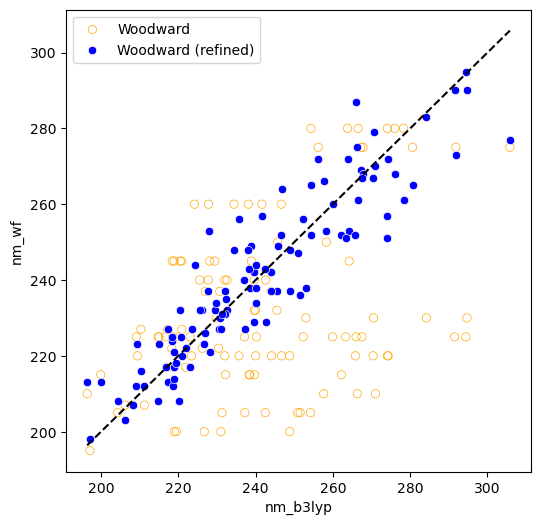

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

sns.scatterplot(
    data=df_4fit_wf,
    x='nm_b3lyp',
    y='nm_wf',
    marker='o',
    facecolors='none',
    edgecolor='orange',
    label='Woodward'
)

# Plot hollow circles for 'nm_wfe'
sns.scatterplot(
    data=df_4fit_wf,
    x='nm_b3lyp',
    y='nm_wf_refine',
    marker='o',
    color='blue',
    label='Woodward (refined)'
)

# Add identity line for reference
plt.plot([df_4fit_wf['nm_b3lyp'].min(), df_4fit_wf['nm_b3lyp'].max()],
         [df_4fit_wf['nm_b3lyp'].min(), df_4fit_wf['nm_b3lyp'].max()],
         'k--', label='y = x')
